In [1]:


#rcParams['savefig.dpi'] = 75

#from mpl_toolkits.basemap import Basemap
%matplotlib inline
from matplotlib.pylab import *
import numpy as np

from sigvisa import Sigvisa
from sigvisa.source.event import get_event
from sigvisa.signals.io import fetch_waveform, EventNotDetected, MissingWaveform
from sigvisa.models.ttime import tt_predict
from sigvisa.graph.sigvisa_graph import SigvisaGraph

import cPickle as pickle

from sigvisa.infer.correlations.historical_signal_library import get_historical_signals
from sigvisa.infer.correlations.weighted_event_posterior import compute_atime_posteriors, align_sum, wn_origin_posterior


In [80]:
# load SG with birthed large event
with open("/home/dmoore/python/sigvisa/logs/mcmc/01478/proposals/proposal_00001/pickle.sg", "rb") as f:
    sg = pickle.load(f)

#stas = ["ELK",]
stas=None
#proposals = get_historical_signals(sg, stas=stas)

wn = sg.station_waves["ELK"][0]
gps = wn.wavelet_param_models["Lg"]

781


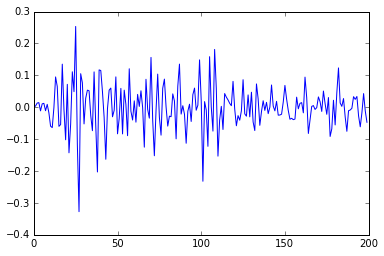

In [81]:
# pick an event to propose from
# heatmap-plot 
# - the surrogate likelihood at a single station
# - surrogate likelihood for all stations
# - Gaussians based on those two

print len(proposals)
x = proposals[648][0]
plt.plot(proposals[648][1][('ELK', 'BHZ', 'freq_0.8_4.5', 'Lg')])

In [82]:
xx = x[:, :3]
print xx
base_means = [gp.predict(cond=xx) for gp in gps]
base_variances = [gp.variance(cond=xx, include_obs=True) for gp in gps]

[[-114.9033   41.1945    5.4   ]]


In [83]:
eps = np.array(((1e-2, 1e-2, 0.0)))
eps_means = [gp.predict(cond=xx+eps) for gp in gps]
eps_variances = [gp.variance(cond=xx+eps, include_obs=True) for gp in gps]

In [84]:
from sigvisa.models.joint_gp import multiply_scalar_gaussian
def gaussian_normalizer(means1, vars1, means2, vars2):
    Z = 0.0
    for (m1, v1, m2, v2) in zip(means1, vars1, means2, vars2):
        m, v, ZZ = multiply_scalar_gaussian(m1, v1, m2, v2)
        Z += ZZ
    return Z

def wavelet_divergence_loc(lon, lat):
    xd = np.array(((lon, lat, 5.4),))
    return wavelet_divergence(xd)
    
def wavelet_divergence(xd):
    xd = np.asarray(xd).reshape((1, -1))
    eps_means = [gp.predict(cond=xd) for gp in gps]
    eps_variances = [gp.variance(cond=xd, include_obs=True) for gp in gps]
    return gaussian_normalizer(base_means, base_variances, eps_means, eps_variances)
    
print wavelet_divergence_loc(-114.91, 41.21)

-180.329991021


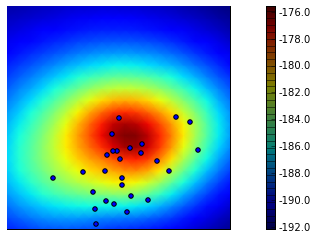

In [85]:
from sigvisa.plotting.heatmap import Heatmap
x0 = np.array((-114.9033, 41.1945))
hm = Heatmap(f=wavelet_divergence_loc, n=20, 
             center=x0, width_deg=0.2, 
             height_deg=0.2, calc=True)
hm.init_bmap(axes=plt.gca())
hm.plot_density(smooth=True)
hm.bmap.scatter(gps[0].X[:, 0], gps[0].X[:, 1], s=20, zorder=10)

In [86]:
import numdifftools as nd
x0d = np.array((-114.9033, 41.1945, 5.4))
hf = nd.Hessian(wavelet_divergence)
H=  hf(x0d)

In [87]:
cov = np.linalg.inv(-H)
print cov

[[  1.33080551e-04  -1.27397986e-05  -1.15217575e-04]
 [ -1.27397986e-05   8.95348838e-05  -3.81143812e-04]
 [ -1.15217575e-04  -3.81143812e-04   5.02801971e+00]]


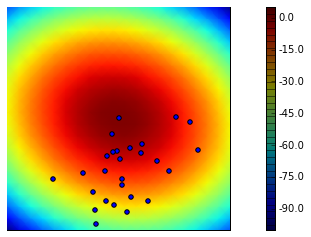

In [88]:
import scipy.stats
rv = scipy.stats.multivariate_normal(mean=x0d, cov=cov)
def proxy_lp(lon, lat):
    xd = np.array((lon, lat, 5.4))
    return rv.logpdf(xd)

x0 = np.array((-114.9033, 41.1945))
hm = Heatmap(f=proxy_lp, n=20, 
             center=x0, width_deg=0.2, 
             height_deg=0.2, calc=True)
hm.init_bmap(axes=plt.gca())
hm.plot_density(smooth=True)
hm.bmap.scatter(gps[0].X[:, 0], gps[0].X[:, 1], s=20, zorder=10)

In [89]:
print rv.rvs(20)

[[-114.88906275   41.18570519    5.26197388]
 [-114.91805155   41.19316234    3.76254617]
 [-114.90557173   41.19610696    5.70430595]
 [-114.91562093   41.19488538    7.55860813]
 [-114.88745652   41.19993548    3.44573136]
 [-114.89623149   41.19925714    3.32621432]
 [-114.89790002   41.19711349    4.17191312]
 [-114.88579868   41.18539924    7.74953081]
 [-114.89677168   41.19013917    6.88659727]
 [-114.90902245   41.20088486    8.4231234 ]
 [-114.89200561   41.2107484     3.64741355]
 [-114.91519345   41.20873555    6.11018185]
 [-114.89363159   41.19645834    5.49370141]
 [-114.89732313   41.19334623    3.72547177]
 [-114.89852355   41.20486779    3.10076073]
 [-114.90408237   41.19757042    3.81555538]
 [-114.93139527   41.20483362    4.25327423]
 [-114.89672913   41.17903596    1.6814815 ]
 [-114.89693357   41.20004343    3.17833118]
 [-114.89954113   41.18847108    4.84852138]]
